# ATP Tennis Predictions Using Player History/Matchup Data

In our previous [notebook](https://github.com/sv650s/sb-capstone2/blob/master/notebooks/7-apt_advanced_feature_engineering.ipynb), we created new datasets with player history leading up to the match as well as matchup history between the 2 players. Player history is based on the most recent 5 matches played and matchup history is also based on the most recent 5 matches played

In this notebook, we will run our models with these datasets to see if we get improvements from the new data

Our best performing model so far is Random Forest using our basic diff dataset where we diffed available player stats between the 2 players and created features from them and using data from 1998 to 2019

### Results from Random Forest using diff dataset:

Random Forest Accruacy score: 0.8524918780673256

```
              precision    recall  f1-score   support

        Loss       0.82      0.90      0.86      7115
         Win       0.89      0.81      0.85      7352

    accuracy                           0.85     14467
   macro avg       0.86      0.85      0.85     14467
weighted avg       0.86      0.85      0.85     14467
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import pickle
import json

%matplotlib inline
sns.set()


# date
DATE_FORMAT = '%Y-%m-%d'
DATE = datetime.now().strftime(DATE_FORMAT)

# files
DATASET_DIR = '../datasets'
FEATURE_FILE_DIFF = f'{DATASET_DIR}/atp_matches_1998-2019_features-diff-matchup5.csv'
FEATURE_FILE_1985_DIFF = f'{DATASET_DIR}/atp_matches_1985-2019_features-diff-matchup5.csv'
FEATURE_FILE_DIFF_OHE = f'{DATASET_DIR}/atp_matches_1998-2019_features-diff-ohe-matchup5.csv'
FEATURE_FILE_1985_DIFF_OHE = f'{DATASET_DIR}/atp_matches_1985-2019_features-diff-ohe-matchup5.csv'

START_YEAR = 1998
END_YEAR = 2019

MODEL_DIR = '../models'
MODEL_FILE_KNN = f'{MODEL_DIR}/knn-{START_YEAR}-{END_YEAR}-diff-matchup5.pkl'
MODEL_FILE_LR = f'{MODEL_DIR}/lr-{START_YEAR}-{END_YEAR}-diff-matchup5.pkl'
MODEL_FILE_RF = f'{MODEL_DIR}/rf-{START_YEAR}-{END_YEAR}-diff-matchup5.pkl'
MODEL_FILE_KNN_OHE = f'{MODEL_DIR}/knn-{START_YEAR}-{END_YEAR}-diff-ohe-matchup5.pkl'
MODEL_FILE_LR_OHE = f'{MODEL_DIR}/lr-{START_YEAR}-{END_YEAR}-diff-ohe-matchup5.pkl'
MODEL_FILE_RF_OHE = f'{MODEL_DIR}/rf-{START_YEAR}-{END_YEAR}-diff-ohe-matchup5.pkl'

LABEL_COL = 'p1_winner'

# random seed
RSTATE = 1
N_JOBS = 4
MAX_ITER = 100



In [2]:
def analyze_predictions(model, X_test, y_test, y_predict, y_predict_proba=None):
    print(f'Model Score: {model.score(X_test, y_test)}')
    
    if y_predict_proba:
        print(roc_auc_score(y_test, y_predict_proba))
    
    print(classification_report(y_test, y_predict, target_names=['Loss', 'Win']))
    cm = pd.DataFrame(confusion_matrix(y_test, y_predict), index=['Loss', 'Win'], 
                  columns = ['Loss', 'Win'])
    print(cm)
    sns.heatmap(cm, annot=True)
    
    

def plot_2d(X_test, y_predict):
    """
    Use PCA to dimensionality reduction then plot win vs loses
    :param: X_test - test features
    :param: y_predict - predictions from model
    """
    
    # normalize our data first before using PCA so weights are the same for all variables
    mms = MinMaxScaler()
    normalized_df = X_test.copy()
    for col in normalized_df.columns:
        normalized_col = mms.fit_transform([normalized_df[col].values])
        normalized_df[col] = normalized_col[-1]
    

    # reduce X to 2D
    X_test_2d = pd.DataFrame(PCA(n_components=2).fit_transform(X_test))

    # let's figure out which ones of these are predicted Wins
    wins = X_test_2d[y_predict == 1]

    # entries that are predicted losses
    losses = X_test_2d[y_predict == 0]

    f, a = plt.subplots(1, 1, figsize=(20,5))
    p = sns.scatterplot(x=0, y=1, data=losses, ax=a, color='r', alpha=0.25)
    p = sns.scatterplot(x=0, y=1, data=wins, ax=a, color='b', alpha=0.25)


# Reading in our data

In [3]:
# extract features and labels
features = pd.read_csv(f'{FEATURE_FILE_DIFF}')
labels = features[LABEL_COL].copy()
features = features.drop([LABEL_COL], axis=1)

# train our model
X_train, X_test, y_train, y_test = \
        train_test_split(features, labels, random_state=RSTATE)

In [22]:
np.sort(features.columns)

array(['age_diff', 'draw_size', 'ht_diff', 'p1', 'p1_games_lost',
       'p1_games_won', 'p1_games_won_percentage', 'p1_hand', 'p1_ioc',
       'p1_losses', 'p1_matchup_games', 'p1_matchup_games_won_percentage',
       'p1_matchup_losses', 'p1_matchup_sets',
       'p1_matchup_sets_won_percentage', 'p1_matchup_win_percentage',
       'p1_matchup_wins', 'p1_sets_lost', 'p1_sets_won',
       'p1_sets_won_percentage', 'p1_win_percentage', 'p1_wins', 'p2',
       'p2_games_lost', 'p2_games_won', 'p2_games_won_percentage',
       'p2_hand', 'p2_ioc', 'p2_losses', 'p2_matchup_games',
       'p2_matchup_losses', 'p2_matchup_sets', 'p2_matchup_wins',
       'p2_sets_lost', 'p2_sets_won', 'p2_sets_won_percentage',
       'p2_win_percentage', 'p2_wins', 'rank_diff', 'round_label',
       'seed_diff', 'surface_label', 'tourney_id_label',
       'tourney_level_label', 'tourney_month', 'tourney_year'],
      dtype=object)

In [24]:
DELETE_COLUMNS = ["p1_games_won", "p1_losses", "p1_matchup_games", "p1_matchup_losses", "p1_matchup_sets", "p1_matchup_wins", "p1_sets_lost", "p1_sets_won", "p1_wins"]
DELETE_COLUMNS.extend([col.replace("p1", "p2") for col in DELETE_COLUMNS])
DELETE_COLUMNS

['p1_games_won',
 'p1_losses',
 'p1_matchup_games',
 'p1_matchup_losses',
 'p1_matchup_sets',
 'p1_matchup_wins',
 'p1_sets_lost',
 'p1_sets_won',
 'p1_wins',
 'p2_games_won',
 'p2_losses',
 'p2_matchup_games',
 'p2_matchup_losses',
 'p2_matchup_sets',
 'p2_matchup_wins',
 'p2_sets_lost',
 'p2_sets_won',
 'p2_wins']

## Logistic Regression

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.3s finished


Model Score: 0.6927280086346466
              precision    recall  f1-score   support

        Loss       0.70      0.66      0.68      7378
         Win       0.68      0.72      0.70      7446

    accuracy                           0.69     14824
   macro avg       0.69      0.69      0.69     14824
weighted avg       0.69      0.69      0.69     14824

      Loss   Win
Loss  4901  2477
Win   2078  5368


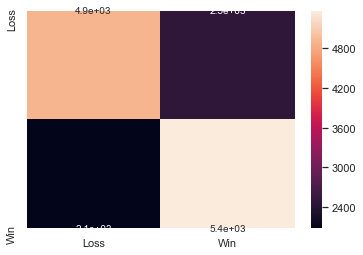

In [4]:
lr = LogisticRegression(n_jobs = N_JOBS, verbose = 1, max_iter = MAX_ITER, random_state = RSTATE, solver = 'lbfgs').fit(X_train, y_train)
y_predict_lr = lr.predict(X_test)

analyze_predictions(lr, X_test, y_test, y_predict_lr)

In [5]:
pickle.dump(lr, open(MODEL_FILE_LR, 'wb'))

## KNN

Model Score: 0.6080005396654075
              precision    recall  f1-score   support

        Loss       0.61      0.61      0.61      7378
         Win       0.61      0.61      0.61      7446

    accuracy                           0.61     14824
   macro avg       0.61      0.61      0.61     14824
weighted avg       0.61      0.61      0.61     14824

      Loss   Win
Loss  4503  2875
Win   2936  4510


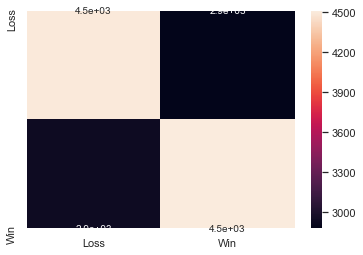

In [6]:
knn = KNeighborsClassifier(n_jobs = N_JOBS).fit(X_train, y_train)
y_predict_knn = knn.predict(X_test)

analyze_predictions(knn, X_test, y_test, y_predict_knn)

In [7]:
pickle.dump(knn, open(MODEL_FILE_KNN, 'wb'))

## Random Forest

//anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


Model Score: 0.815636805180788
              precision    recall  f1-score   support

        Loss       0.79      0.86      0.82      7378
         Win       0.85      0.77      0.81      7446

    accuracy                           0.82     14824
   macro avg       0.82      0.82      0.82     14824
weighted avg       0.82      0.82      0.82     14824

      Loss   Win
Loss  6327  1051
Win   1682  5764


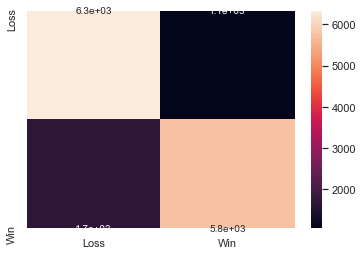

In [8]:
rf = RandomForestClassifier(random_state=RSTATE, verbose=1).fit(X_train, y_train)
y_predict_rf = rf.predict(X_test)

analyze_predictions(rf, X_test, y_test, y_predict_rf)

In [9]:
pickle.dump(rf, open(MODEL_FILE_RF, 'wb'))

# Reading in One Hot Encoded Data With History/Matchup

In [10]:
# extract features and labels
features_ohe = pd.read_csv(f'{FEATURE_FILE_DIFF_OHE}')
labels_ohe = features_ohe[LABEL_COL].copy()
features_ohe = features_ohe.drop([LABEL_COL], axis=1)

# train our model
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = \
        train_test_split(features_ohe, labels, random_state=RSTATE)

## Logistic Regression

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  4.0min finished


Model Score: 0.6971127900701565
              precision    recall  f1-score   support

        Loss       0.70      0.68      0.69      7378
         Win       0.69      0.72      0.70      7446

    accuracy                           0.70     14824
   macro avg       0.70      0.70      0.70     14824
weighted avg       0.70      0.70      0.70     14824

      Loss   Win
Loss  4986  2392
Win   2098  5348


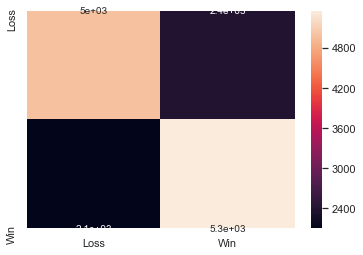

In [12]:
lr_ohe = LogisticRegression(n_jobs = N_JOBS, verbose = 1, max_iter = MAX_ITER, random_state = RSTATE, solver = 'lbfgs').fit(X_train_ohe, y_train_ohe)
y_predict_lr_ohe = lr_ohe.predict(X_test_ohe)

analyze_predictions(lr_ohe, X_test_ohe, y_test_ohe, y_predict_lr_ohe)

In [13]:
pickle.dump(lr_ohe, open(MODEL_FILE_LR_OHE, 'wb'))

## KNN

Model Score: 0.7947247706422018
              precision    recall  f1-score   support

        Loss       0.78      0.82      0.80      7378
         Win       0.81      0.77      0.79      7446

    accuracy                           0.79     14824
   macro avg       0.80      0.79      0.79     14824
weighted avg       0.80      0.79      0.79     14824

      Loss   Win
Loss  6077  1301
Win   1742  5704


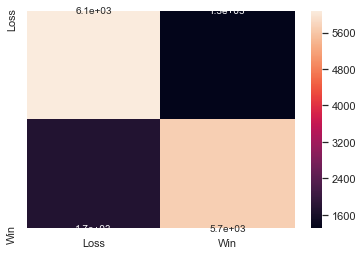

In [14]:
knn_ohe = KNeighborsClassifier(n_jobs = N_JOBS).fit(X_train_ohe, y_train_ohe)
y_predict_knn_ohe = knn_ohe.predict(X_test_ohe)

analyze_predictions(knn_ohe, X_test_ohe, y_test_ohe, y_predict_knn_ohe)

In [15]:
pickle.dump(knn_ohe, open(MODEL_FILE_KNN_OHE, 'wb'))

## Random Forest

//anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


Model Score: 0.7122908796546141
              precision    recall  f1-score   support

        Loss       0.69      0.77      0.73      7378
         Win       0.74      0.65      0.69      7446

    accuracy                           0.71     14824
   macro avg       0.72      0.71      0.71     14824
weighted avg       0.72      0.71      0.71     14824

      Loss   Win
Loss  5705  1673
Win   2592  4854


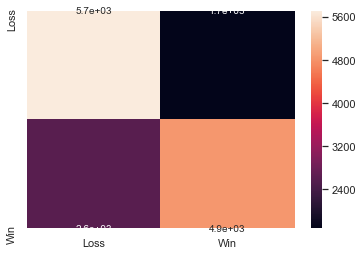

In [16]:
rf_ohe = RandomForestClassifier(random_state=RSTATE, verbose=1).fit(X_train_ohe, y_train_ohe)
y_predict_rf_ohe = rf_ohe.predict(X_test_ohe)

analyze_predictions(rf_ohe, X_test_ohe, y_test_ohe, y_predict_rf_ohe)

In [17]:
pickle.dump(rf_ohe, open(MODEL_FILE_RF_OHE, 'wb'))